# Assignment 3: Word2Vec

In this assignment, we will see how we can use Word2Vec (or any similar word embedding) to use information from unlabelled data to help us classify better!

You will be using the sentiment data from last week, either the yelps or movies, whichever you wish. 

Your goal will be to simulate the following situation: you have a **small** set of labelled data and a large set of unlabelled data. Show how the two follow 2 techniques compare as the amount of labelled data increases. You should train them on the small labelled subset and test their performance on the rest of the data. 

In other words, train on 1k, test on 99k. Then train on 2k, test on 98k. Then train on 4k, test on 96k. Etc.

1. Logistic regression trained on labelled data, documents represented as term-frequency matrix of your choice. You can learn the vocabulary from the entire dataset or only the labelled data.

2. Logistic regression trained on the labelled data, documents represented as word2vec vectors where you train word2vec using the entire dataset. Play around with different settings of word2vec (training window size, K-negative, skip-gram vs BOW, training windows, etc.). Note: we didn't go over the options in detail in class, so you will need to read about them a bit!

You can read about the gensime word2vec implementation [here](https://radimrehurek.com/gensim/models/word2vec.html).

# Comment
There are a few things that confuse me, above all that the vectorizer works better than work2vec. 
I would have liked to try more combinations, but it really takes ages to run. Perhaps its my machine or inefficient coding, but it unfortunately wasnt feasible.

In [13]:
import matplotlib.pyplot as plt
import re
import spacy
import seaborn as sns
import pandas as pd
import numpy as np
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
import numpy as np
from sklearn.decomposition import PCA
import pandas as pd
import random
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import nltk as nl
from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec

In [14]:
stemmer = SnowballStemmer("english")
not_alphanumeric_or_space = re.compile('[^(\w|\s|\d)]')
nlp = spacy.load('en_core_web_sm')

def preprocess1(doc):
    doc = re.sub(not_alphanumeric_or_space, '', doc)
    words = [t.lemma_ for t in nlp(doc) if t.lemma_ != '-PRON-']
    return ' '.join(words).lower()

def preprocess2(doc):
    doc = re.sub(not_alphanumeric_or_space, '', doc)
    words = [t.lemma_ for t in nlp(doc) if (t.lemma_ != '-PRON-' and t.lemma_!='\n')]
    return words

In [15]:
yelps = pd.read_csv('../text-mining-2020-classifying-text-muellerm-95/sentiment/yelps.csv').sample(frac=1.)

In [16]:
yelps=yelps.sample(frac=1.)

In [17]:
yelps.shape

(100003, 3)

In [ ]:
y=np.array(yelps.positive)
X=yelps.text.to_list()
docs=[preprocess2(doc) for doc in X]

In [24]:
# train model on full set
model = Word2Vec(min_count=1,size=50)
model.build_vocab(docs)
model.train(docs, total_examples=model.corpus_count, epochs=5)

(39531973, 55015735)

In [26]:
import pickle
filename = 'w2v.sav'
pickle.dump(model, open(filename, 'wb'))

In [27]:
filename = 'docs.sav'
pickle.dump(docs, open(filename, 'wb'))

In [43]:
X_w2v=[]
for doc in docs:
    docvec=np.zeros(shape=(50,))
    for word in doc:
        docvec+=model.wv[word]
    docvec=docvec/np.linalg.norm(docvec)
    X_w2v+=[docvec.tolist()]
X_w2v=np.asarray(X_w2v)

# replace possible nans
col_mean = np.nanmean(X_w2v, axis=0)
inds = np.where(np.isnan(X_w2v))
X_w2v[inds]=np.take(col_mean, inds[1])

<ipython-input-43-8b8884a123a1>:6: RuntimeWarning: invalid value encountered in true_divide
  docvec=docvec/np.linalg.norm(docvec)


Currently at test size 0.01
split done
vecotizer done
logistic regression 1 done
logistic regression 2 done
Currently at test size 0.02
split done


/home/maximilian/anaconda2/envs/py36/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:382: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


vecotizer done
logistic regression 1 done
logistic regression 2 done
Currently at test size 0.04
split done


/home/maximilian/anaconda2/envs/py36/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:382: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


vecotizer done
logistic regression 1 done
logistic regression 2 done
Currently at test size 0.08
split done


/home/maximilian/anaconda2/envs/py36/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:382: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


vecotizer done
logistic regression 1 done
logistic regression 2 done
Currently at test size 0.16
split done


/home/maximilian/anaconda2/envs/py36/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:382: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


vecotizer done


/home/maximilian/anaconda2/envs/py36/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


logistic regression 1 done
logistic regression 2 done


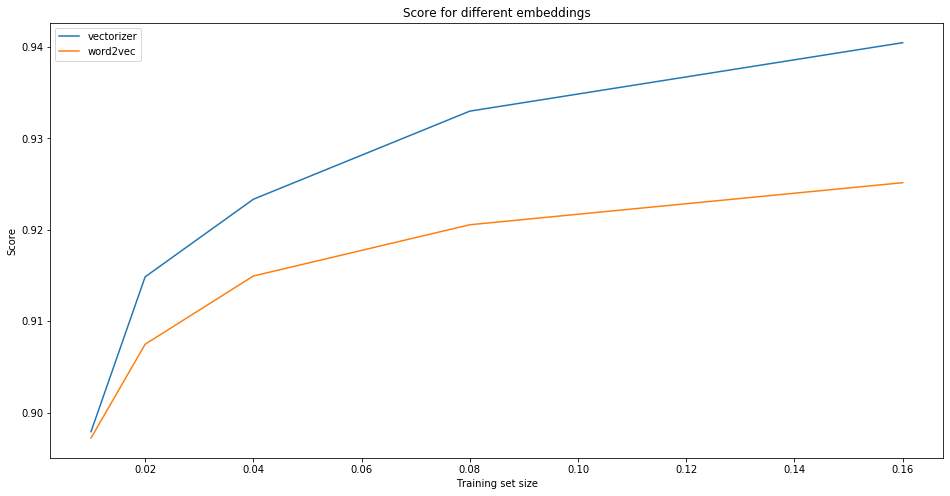

In [45]:
# try cbow and window size 5
df=pd.DataFrame(columns=['method','test_size','score'])
test_size_range=[0.01,0.02,0.04,0.08,0.16]
for test_size in test_size_range:
    print('Currently at test size {}'.format(test_size))

    # train test split
    X_train, X_test, y_train, y_test = train_test_split(
        docs, y, test_size=(1-test_size), random_state=42)
    
    X_train2, X_test2, y_train2, y_test2 = train_test_split(
        X_w2v, y, test_size=(1-test_size), random_state=42)
    
    print('split done')
    
    # initialize vectorizer
    vectorizer = TfidfVectorizer(min_df=2,
                                 max_df=.8,
                                 preprocessor=preprocess1,
                                 stop_words='english',
                                 use_idf=False,
                                 norm=False)
    
    # transform for vectorizer
    X_train1 = vectorizer.fit_transform([' '.join(doc) for doc in X_train])
    X_test1 = vectorizer.transform([' '.join(doc) for doc in X_test])

    print('vectorizer done')
    
    # logistic regr with vectorized data
    clf1=LogisticRegression(random_state=0)
    clf1.fit(X_train1,y_train)
    preds1=clf1.predict(X_test1)
    score1=sum(y_test==preds1)/len(preds1)
    
    print('logistic regression 1 done')

    # append result to df
    df=df.append({'method':'vectorizer','test_size':test_size,'score':score1},ignore_index=True)

    # perform logistic regression
    clf2=LogisticRegression(random_state=0)
    clf2.fit(X_train2,y_train2)
    preds2=clf2.predict(X_test2)
    score2=sum(y_test2==preds2)/len(preds2)
    
    print('logistic regression 2 done')
    
    # append result to df
    df=df.append({'method':'word2vec','test_size':test_size,'score':score2},ignore_index=True)

vec_df=df[df.method=='vectorizer']
word_df=df[df.method=='word2vec']

plt.figure(figsize=(16,8))
plt.plot(vec_df.test_size,vec_df.score,label='vectorizer')
plt.plot(word_df.test_size,word_df.score,label='word2vec')
plt.title('Score for different embeddings')
plt.xlabel('Training set size')
plt.ylabel('Score')
plt.legend()

In [47]:
# train model on full set
model2 = Word2Vec(min_count=1,size=50,window=5,sg=0)
model2.build_vocab(docs)
model2.train(docs, total_examples=model.corpus_count, epochs=5)

X_w2v2=[]
for doc in docs:
    docvec=np.zeros(shape=(50,))
    for word in doc:
        docvec+=model2.wv[word]
    docvec=docvec/np.linalg.norm(docvec)
    X_w2v2+=[docvec.tolist()]
X_w2v2=np.asarray(X_w2v2)

# replace possible nans
col_mean2 = np.nanmean(X_w2v2, axis=0)
inds = np.where(np.isnan(X_w2v2))
X_w2v2[inds]=np.take(col_mean2, inds[1])

<ipython-input-47-d8b008afd221>:11: RuntimeWarning: invalid value encountered in true_divide
  docvec=docvec/np.linalg.norm(docvec)


Currently at test size 0.01
split done


/home/maximilian/anaconda2/envs/py36/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:382: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


vectorizer done
logistic regression 1 done
logistic regression 2 done
Currently at test size 0.02
split done


/home/maximilian/anaconda2/envs/py36/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:382: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


vectorizer done
logistic regression 1 done
logistic regression 2 done
Currently at test size 0.04
split done


/home/maximilian/anaconda2/envs/py36/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:382: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


vectorizer done
logistic regression 1 done
logistic regression 2 done
Currently at test size 0.16
split done


/home/maximilian/anaconda2/envs/py36/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:382: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


vectorizer done


/home/maximilian/anaconda2/envs/py36/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


logistic regression 1 done
logistic regression 2 done


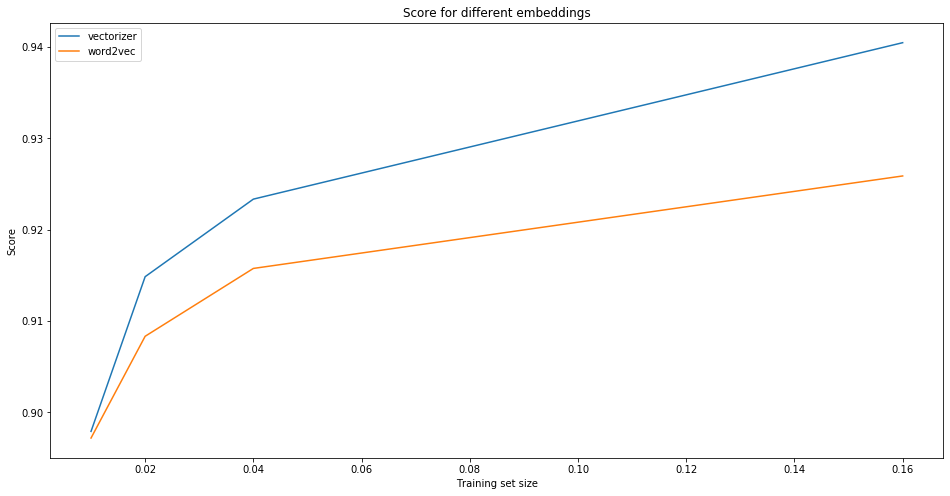

In [48]:
# try cbow and window size 5
df=pd.DataFrame(columns=['method','test_size','score'])
test_size_range=[0.01,0.02,0.04,0.16]
for test_size in test_size_range:
    print('Currently at test size {}'.format(test_size))

    # train test split
    X_train, X_test, y_train, y_test = train_test_split(
        docs, y, test_size=(1-test_size), random_state=42)
    
    X_train2, X_test2, y_train2, y_test2 = train_test_split(
        X_w2v2, y, test_size=(1-test_size), random_state=42)
    
    print('split done')
    
    # initialize vectorizer
    vectorizer = TfidfVectorizer(min_df=2,
                                 max_df=.8,
                                 preprocessor=preprocess1,
                                 stop_words='english',
                                 use_idf=False,
                                 norm=False)
    
    # transform for vectorizer
    X_train1 = vectorizer.fit_transform([' '.join(doc) for doc in X_train])
    X_test1 = vectorizer.transform([' '.join(doc) for doc in X_test])

    print('vectorizer done')
    
    # logistic regr with vectorized data
    clf1=LogisticRegression(random_state=0)
    clf1.fit(X_train1,y_train)
    preds1=clf1.predict(X_test1)
    score1=sum(y_test==preds1)/len(preds1)
    
    print('logistic regression 1 done')

    # append result to df
    df=df.append({'method':'vectorizer','test_size':test_size,'score':score1},ignore_index=True)

    # perform logistic regression
    clf2=LogisticRegression(random_state=0)
    clf2.fit(X_train2,y_train2)
    preds2=clf2.predict(X_test2)
    score2=sum(y_test2==preds2)/len(preds2)
    
    print('logistic regression 2 done')
    
    # append result to df
    df=df.append({'method':'word2vec','test_size':test_size,'score':score2},ignore_index=True)

vec_df=df[df.method=='vectorizer']
word_df=df[df.method=='word2vec']

plt.figure(figsize=(16,8))
plt.plot(vec_df.test_size,vec_df.score,label='vectorizer')
plt.plot(word_df.test_size,word_df.score,label='word2vec')
plt.title('Score for different embeddings')
plt.xlabel('Training set size')
plt.ylabel('Score')
plt.legend()

In [49]:
# try skip-gram and window size 10
# train model on full set
model3 = Word2Vec(min_count=1,size=50,window=10,sg=1)
model3.build_vocab(docs)
model3.train(docs, total_examples=model.corpus_count, epochs=5)

X_w2v3=[]
for doc in docs:
    docvec=np.zeros(shape=(50,))
    for word in doc:
        docvec+=model3.wv[word]
    docvec=docvec/np.linalg.norm(docvec)
    X_w2v3+=[docvec.tolist()]
X_w2v3=np.asarray(X_w2v3)

# replace possible nans
col_mean3 = np.nanmean(X_w2v3, axis=0)
inds = np.where(np.isnan(X_w2v3))
X_w2v3[inds]=np.take(col_mean3, inds[1])

<ipython-input-49-a29019c190cb>:12: RuntimeWarning: invalid value encountered in true_divide
  docvec=docvec/np.linalg.norm(docvec)


In [ ]:
df=pd.DataFrame(columns=['method','test_size','score'])
test_size_range=[0.01,0.02,0.04,0.16]
for test_size in test_size_range:
    print('Currently at test size {}'.format(test_size))

    # train test split
    X_train, X_test, y_train, y_test = train_test_split(
        docs, y, test_size=(1-test_size), random_state=42)
    
    X_train2, X_test2, y_train2, y_test2 = train_test_split(
        X_w2v3, y, test_size=(1-test_size), random_state=42)
    
    print('split done')
    
    # initialize vectorizer
    vectorizer = TfidfVectorizer(min_df=2,
                                 max_df=.8,
                                 preprocessor=preprocess1,
                                 stop_words='english',
                                 use_idf=False,
                                 norm=False)
    
    # transform for vectorizer
    X_train1 = vectorizer.fit_transform([' '.join(doc) for doc in X_train])
    X_test1 = vectorizer.transform([' '.join(doc) for doc in X_test])

    print('vectorizer done')
    
    # logistic regr with vectorized data
    clf1=LogisticRegression(random_state=0)
    clf1.fit(X_train1,y_train)
    preds1=clf1.predict(X_test1)
    score1=sum(y_test==preds1)/len(preds1)
    
    print('logistic regression 1 done')

    # append result to df
    df=df.append({'method':'vectorizer','test_size':test_size,'score':score1},ignore_index=True)

    # perform logistic regression
    clf2=LogisticRegression(random_state=0)
    clf2.fit(X_train2,y_train2)
    preds2=clf2.predict(X_test2)
    score2=sum(y_test2==preds2)/len(preds2)
    
    print('logistic regression 2 done')
    
    # append result to df
    df=df.append({'method':'word2vec','test_size':test_size,'score':score2},ignore_index=True)

vec_df=df[df.method=='vectorizer']
word_df=df[df.method=='word2vec']

plt.figure(figsize=(16,8))
plt.plot(vec_df.test_size,vec_df.score,label='vectorizer')
plt.plot(word_df.test_size,word_df.score,label='word2vec')
plt.title('Score for different embeddings')
plt.xlabel('Training set size')
plt.ylabel('Score')
plt.legend()

Currently at test size 0.01
split done


/home/maximilian/anaconda2/envs/py36/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:382: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


vectorizer done
logistic regression 1 done
logistic regression 2 done
Currently at test size 0.02
split done


/home/maximilian/anaconda2/envs/py36/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:382: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


vectorizer done
logistic regression 1 done
logistic regression 2 done
Currently at test size 0.04
split done


/home/maximilian/anaconda2/envs/py36/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:382: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [ ]:
# try skip-gram and window size 5, add negative sampling
model4 = Word2Vec(docs, min_count=1,size=50,window=5,sg=1,ng=1)
model4.build_vocab(docs)
model4.train(docs, total_examples=model.corpus_count, epochs=5)

X_w2v4=[]
for doc in docs:
    docvec=np.zeros(shape=(50,))
    for word in doc:
        docvec+=model4.wv[word]
    docvec=docvec/np.linalg.norm(docvec)
    X_w2v4+=[docvec.tolist()]
X_w2v4=np.asarray(X_w2v4)

# replace possible nans
col_mean4 = np.nanmean(X_w2v4, axis=0)
inds = np.where(np.isnan(X_w2v4))
X_w2v4[inds]=np.take(col_mean4, inds[1])

In [ ]:
# try skip-gram and window size 5, add negative sampling
df=pd.DataFrame(columns=['method','test_size','score'])
test_size_range=[0.01,0.02,0.04,0.16]
for test_size in test_size_range:
    print('Currently at test size {}'.format(test_size))

    # train test split
    X_train, X_test, y_train, y_test = train_test_split(
        docs, y, test_size=(1-test_size), random_state=42)
    
    X_train2, X_test2, y_train2, y_test2 = train_test_split(
        X_w2v4, y, test_size=(1-test_size), random_state=42)
    
    print('split done')
    
    # initialize vectorizer
    vectorizer = TfidfVectorizer(min_df=2,
                                 max_df=.8,
                                 preprocessor=preprocess1,
                                 stop_words='english',
                                 use_idf=False,
                                 norm=False)
    
    # transform for vectorizer
    X_train1 = vectorizer.fit_transform([' '.join(doc) for doc in X_train])
    X_test1 = vectorizer.transform([' '.join(doc) for doc in X_test])

    print('vectorizer done')
    
    # logistic regr with vectorized data
    clf1=LogisticRegression(random_state=0)
    clf1.fit(X_train1,y_train)
    preds1=clf1.predict(X_test1)
    score1=sum(y_test==preds1)/len(preds1)
    
    print('logistic regression 1 done')

    # append result to df
    df=df.append({'method':'vectorizer','test_size':test_size,'score':score1},ignore_index=True)

    # perform logistic regression
    clf2=LogisticRegression(random_state=0)
    clf2.fit(X_train2,y_train2)
    preds2=clf2.predict(X_test2)
    score2=sum(y_test2==preds2)/len(preds2)
    
    print('logistic regression 2 done')
    
    # append result to df
    df=df.append({'method':'word2vec','test_size':test_size,'score':score2},ignore_index=True)

vec_df=df[df.method=='vectorizer']
word_df=df[df.method=='word2vec']

plt.figure(figsize=(16,8))
plt.plot(vec_df.test_size,vec_df.score,label='vectorizer')
plt.plot(word_df.test_size,word_df.score,label='word2vec')
plt.title('Score for different embeddings')
plt.xlabel('Training set size')
plt.ylabel('Score')
plt.legend()